# Step 1: Setup + Imports

In [5]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [6]:
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch import nn, optim
from torchvision.datasets import ImageFolder

In [7]:
# ✅ Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cpu


# Step 2: Define Data Paths + Transforms

In [8]:
# Define paths to your pre-split dataset
data_dir = 'project_data'

train_dir = os.path.join(data_dir, 'train')
val_dir   = os.path.join(data_dir, 'val')
test_dir  = os.path.join(data_dir, 'test')

# ImageNet normalization for EfficientNet
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

# Data transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


# Step 3: Load Datasets & DataLoaders

In [9]:
# Load datasets using ImageFolder
train_data = ImageFolder(train_dir, transform=train_transforms)
val_data   = ImageFolder(val_dir, transform=val_test_transforms)
test_data  = ImageFolder(test_dir, transform=val_test_transforms)

# Map class indices
class_names = train_data.classes
print("Classes:", class_names)

# Create DataLoaders
batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=batch_size, shuffle=False)


Classes: ['fake', 'real']


# Step 4: Load and Modify EfficientNet-B0

In [10]:
# Load EfficientNet-B0 pretrained on ImageNet
model = models.efficientnet_b0(pretrained=True)

for param in model.parameters():
    param.requires_grad = True

# Replace classifier with a custom one for binary classification
model.classifier[1] = nn.Linear(in_features=model.classifier[1].in_features, out_features=2)

model = model.to(device)
print(model)

c:\Users\KIIT\Documents\Programs\New folder\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\KIIT\Documents\Programs\New folder\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

# Step 5: Loss Function, Optimizer, and Training Loop 

In [11]:
# Loss function for classification
criterion = nn.CrossEntropyLoss()

# Optimizer - Adam works well with pre-trained models
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [12]:
# Run training loop directly in notebook to see live output
epochs = 10
train_loss_history = []
val_loss_history = []
best_val_acc = 0.0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    avg_train_loss = running_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    # === Validation ===
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct / total
    val_loss_history.append(avg_val_loss)

    print(
        f"Epoch {epoch+1}/{epochs} - "
        f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
        f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%",
        flush=True
    )

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')


KeyboardInterrupt: 


✅ Test Loss: 0.0065, Test Accuracy: 99.87%

Classification Report:
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00       375
        real       1.00      1.00      1.00       375

    accuracy                           1.00       750
   macro avg       1.00      1.00      1.00       750
weighted avg       1.00      1.00      1.00       750



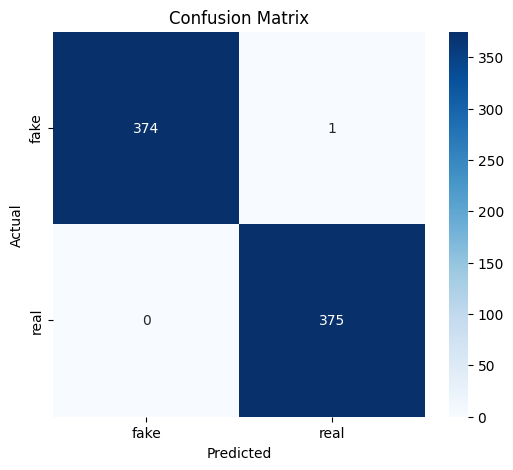

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# === Load the Best Model for Evaluation ===
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.eval()

# === TEST PHASE ===
test_loss = 0.0
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# === Test Metrics ===
test_acc = 100 * correct / total
avg_test_loss = test_loss / len(test_loader)

print(f"\n✅ Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

# === Classification Report ===
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# === Confusion Matrix ===
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


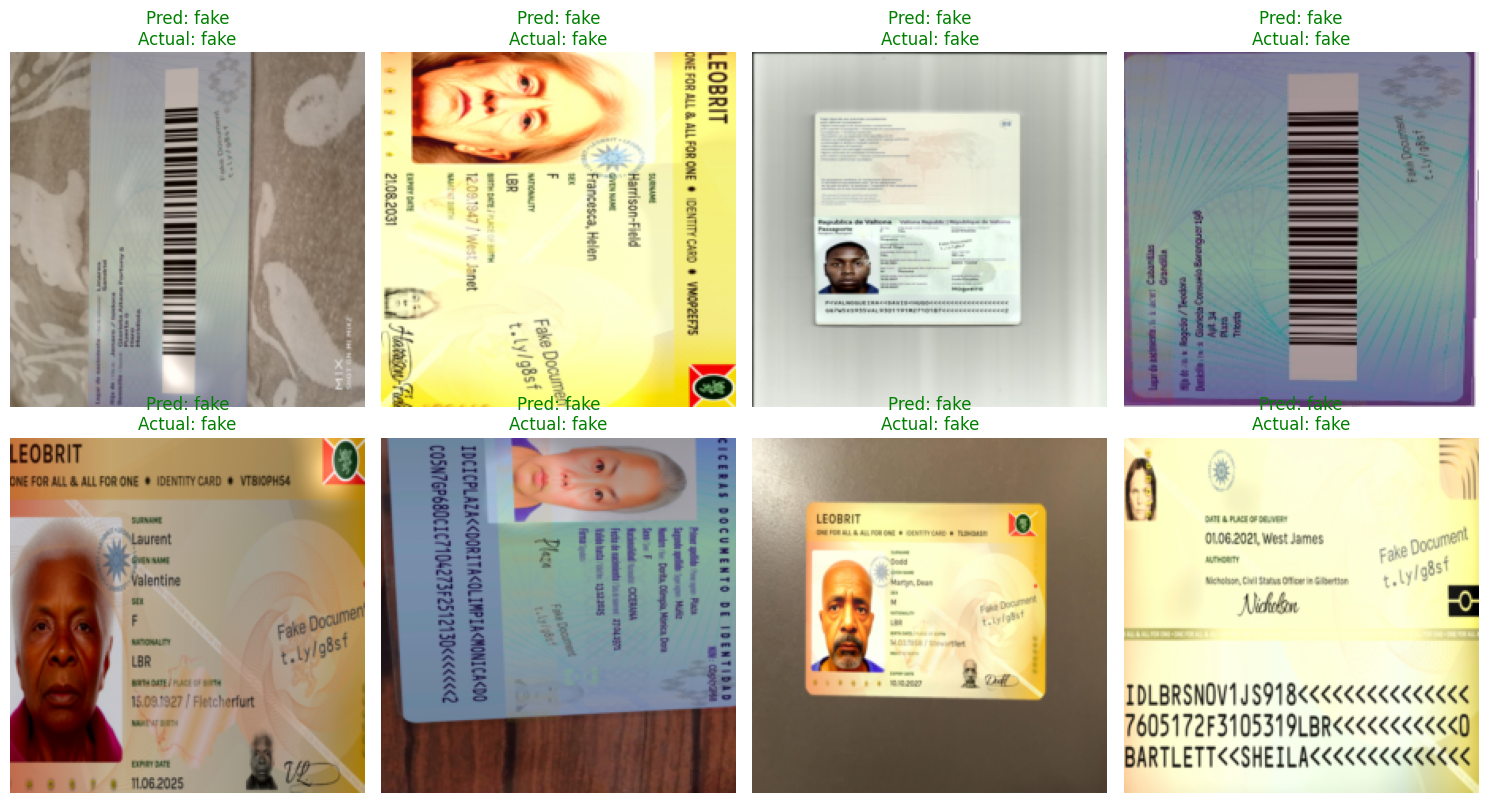

In [14]:
import matplotlib.pyplot as plt

# === Load Best Model First ===
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.eval()

# === Helper: Unnormalize and Show Image ===
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))  # CHW → HWC
    inp = std * inp + mean                 # Unnormalize
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# === Display Predictions on Test Set ===
N = 8  # number of samples to show
shown = 0

plt.figure(figsize=(15, 8))

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        for i in range(inputs.size(0)):
            if shown >= N:
                break
            plt.subplot(2, 4, shown + 1)
            imshow(inputs[i].cpu())

            true_label = class_names[labels[i]]
            pred_label = class_names[preds[i]]

            plt.title(
                f"Pred: {pred_label}\nActual: {true_label}",
                color='green' if pred_label == true_label else 'red'
            )
            shown += 1

        if shown >= N:
            break

plt.tight_layout()
plt.show()
